# Statistical Validation of FIES data

This notebook presents the basic concepts of the food insecurity experience scale, and the validation
of FIES data using the Rasch model. I try to explain how to estimate respondent and item parameters, and how to interpret the Rasch modelbased outputs.


## FIES analysis methodology (Rasch Model)
Item Response Theory (IRT) is a methodology used to analyse responses to survey or test questions.
The Rasch model is one of several models in IRT and is applied for the analysis of FIES data. Item
response theory aims to improve the measurement accuracy and reliability of surveys and tests
through analysis of response data. The item response theory (IRT) measurement model known as
the `Rasch` model provides a theoretical base and a set of statistical tools to:

* assess the suitability of a set of survey items for scale construction
* create a scale from the items, and compare performance of a scale in various populations
and survey contexts.


$$Prob(x_{h,i} = 1|θ_h, β_i) =  \frac {e^{θ_h - β_i}}{1 + e^{θ_h - β_i}}$$

_where $x_{ℎ,𝑖}$ is the response given by respondent *h* to item *i*, coded as 1 for “yes” and 0 for “no”.
The relative severity associated with each of the experiences (the parameters $β_i$
in the formula above) can be inferred from the frequency with which they are reported by a large sample of respondents,  assuming that, all else being equal, more severe experiences are reported by fewer respondents. 
Once the severity of each experience is estimated, the severity of a respondent’s condition (the 𝜃ℎ parameter) can be computed by noting how many of the items have been affirmed._

### Assumptions of the Rasch model
The Rasch model is based upon four key assumptions:
* Only one dimension is represented by the response data. For the FIES, this is the access dimension
of food security
* An individual’s responses to the eight FIES items are correlated with each other only because they are all
conditioned by the severity of food insecurity of that individual.
* The greater the severity of food insecurity experienced by a respondent, the higher the likelihood
that he or she will respond affirmatively to each item
* All items are equally strongly related to the latent trait of food insecurity and differ only in severity.


### Import Libraries and Load the data

In [1]:
import rpy2
import pandas as pd

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
# from pyper import R

%load_ext rpy2.ipython

utils = importr('utils')
# utils.install_packages('anthro')
# utils.install_packages('RM.weights')
pandas2ri.activate()

In [3]:
%%R
library(tidyverse)
library(TAM)
library(WrightMap)
if(!require('RM.weights')) {
  install.packages('RM.weights')
  library('RM.weights')
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Loading required package: CDM
Loading required package: mvtnorm
**********************************
** CDM 8.2-6 (2022-08-25 15:43:23)       
** Cognitive Diagnostic Models  **
**********************************

* TAM 4.1-4 (2022-08-28 16:03:54)
Loading required package: RM.weights
Loading required package: psychotools
Loading required package: Hmisc

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units



### Preparing the data for analysis
Based on standard procedure, extreme raw scores (0 and 8) were excluded to avoid potential bias resulting from large proportions of these raw scores. For more information checkout the VOH document [page 11-12 ](http://www.fao.org/3/a-i4830e.pdf).

In [4]:
df = pd.read_csv("../data/supervised_clean_data.csv", usecols=lambda col:col.startswith("fies"))

print("Before removing extreme values", df.shape)
# Drop extreme values of 0 and 8 as standard procedure
df = df[~df.fies_rawscore.isin([0,8])]
print("After removing extreme values", df.shape)

Before removing extreme values (3441, 9)
After removing extreme values (2583, 9)


In [5]:
%%R

# Define the data file path
file_path <- "../data/fao_round6_ng_clean_data.csv"

# Read the CSV file while selecting columns using the regex pattern
fies.ng <- read_csv(file_path)

fies.ng <- fies.ng %>%
  select(matches("^(fies|weight)"))

# Convert the values to integers
# df <- as.data.frame(lapply(df, as.integer))

# # Drop values with extreme scores 
fies.ng <- subset(fies.ng, !(fies_rawscore %in% c(0.0, 8.0)))

# dim(df)
# head(fies.ng)
dim(fies.ng)

Rows: 3441 Columns: 158
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (19): country, state, local_govt_area, hh_agricactivity, hh_gender, hh_...
dbl (139): hh_size, hh_maritalstat, weight_final, income_main, income_main_c...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 2583   10


## FIES data analysis
The analysis of FIES data involves:

1. **Parameter estimation**: To calculate the level of food insecurity severity associated with each
question and each respondent
2. **Statistical validation**:  To assess whether, depending on the quality of the data collected, the
measure is valid, (i.e. the data are consistent with the theoretical assumptions that inform the
model).
3. **Calculation of food insecurity prevalence estimates**: To calculate a measure of severity of the
food insecurity condition experienced by each respondent, based on their answers to the eight FIES
questions. This is then used to estimate the prevalence of food insecurity at moderate and/or
severe levels in the population.

### 1. Parameter Estimation

To perform **parameter estimation**, Voices of the Hungry (VOH) project provides a free analytical tool ([RM.weight](https://cran.r-project.org/web/packages/RM.weights/index.html)) to facilitate the Rasch
analysis of FIES data. We shall use `RM.weight` and another other statistical software to carry out the analysis.



In [6]:
%%R
# Questionare data and weights
xx.nigeria <- fies.ng[, 2:9]
wt.nigeria <- fies.ng$weight_final

# # Fit weight rasch model
rr.nigeria <- RM.w(xx.nigeria, wt.nigeria)

# # Fit unweighted Rasch
rr.nigeria.nw <- RM.w(xx.nigeria)

dim(fies.ng)


[1] 2583   10


#### **Item Parameters**

The **item parameter** is estimated based on the overall **pattern of responses** given by all
respondents. A question representing a less severe experience will have a **smaller parameter** value,
whereas a question representing a **more severe** experience will have a **larger parameter** value.
The **relative severity** of the items is determined based upon the understanding that the **more severe**
an item is, the **less likely** respondents are to report it. 



In [7]:
%%R
parameter_estimate <- tibble::rownames_to_column(
  data.frame(
    "Item Severity" = rr.nigeria$b,       # Item severity estimate
    "Stardard Error" = rr.nigeria$se.b    # Item standard error
  ),
  var = "Item"
)
parameter_estimate

           Item Item.Severity Stardard.Error
1  fies_worried     -1.632866     0.08150137
2  fies_healthy     -2.510232     0.09712622
3 fies_fewfoods     -2.087363     0.08882218
4  fies_skipped     -1.008383     0.07368368
5  fies_ateless     -1.825110     0.08442171
6   fies_ranout      2.555888     0.06120249
7   fies_hungry      1.715149     0.05876682
8   fies_whlday      4.792783     0.10163146




* There is no absolute interpretation of the numerical values of the parameters, as they only
indicate the relative severity of the items along the scale.


#### **Respondent parameters**

A respondent's raw score is the basis for calculating the respondent parameter.
No matter how many respondents are included in a sample, there will always be up to nine distinct
values of respondent parameters, one for each possible raw score (0-8)

**Respondent parameters** allow us to more precisely evaluate the relative differences in food
insecurity severity along the scale, between the respondents with each raw score.

In [8]:
%%R
respondent_param_estimate <- tibble::rownames_to_column(
  data.frame(
    "Respondent Severity" = rr.nigeria$a,       # Respondent severity for each raw score
    "Stardard Error" = rr.nigeria$se.a,    # Respondent measurement error for each raw score
    "Weighted Class" = rr.nigeria$wt.rs 
  ),
  var = "Item"
)
respondent_param_estimate

  Item Respondent.Severity Stardard.Error Weighted.Class
1    1          -4.1363017      1.5164033        0.00000
2    2          -3.2865482      1.1355167       97.17730
3    3          -2.2680845      0.9293829       94.55714
4    4          -1.4394455      0.9121591      145.76993
5    5          -0.5322047      1.0120611      285.84382
6    6           0.6929257      1.1951842      704.84955
7    7           2.1994420      1.2495743      847.99920
8    8           3.9756342      1.4554552      561.18269
9    9           5.2017987      1.5164033        0.00000


### 2. Statistical Validation- Accessing data quality

Item and respondent parameters estimate from any dataset, does not guarantee that the data are always of acceptable quality so that they can be used to meaningfully measure food insecurity. 
The **statistical validation** process is a fundamental screening tool for assessing data
quality and for evaluating whether a given measure of food insecurity has a solid enough statistical
basis for its intended policy and research uses. 

**FIES analysis methodology**

This involves applying the Rasch Model to the FIES response data and assessing whether the data
conform to the model’s assumptions. 

If the data do conform to the assumptions, we can conclude that the data can be used to calculate a valid measure of food insecurity.

### Fit Statistics 

In [9]:
%%R
fit_statistics <- tibble::rownames_to_column(
  data.frame(
    "Item Severity" = rr.nigeria$b,       # Item severity estimate
    "Stardard Error" = rr.nigeria$se.b,   # Item standard error
    "Infit" = rr.nigeria$infit,            # Infit
    "Std error Infit" = rr.nigeria$se.infit,     # standard error infit
    "Outfit" = rr.nigeria$outfit
  ),
  var = "Item"
)
print(fit_statistics)

#Save to csv
# Comma as separator and dot as decimal separator
write.csv(fit_statistics, "../data/fies_item_statistics.csv")

           Item Item.Severity Stardard.Error     Infit Std.error.Infit
1  fies_worried     -1.632866     0.08150137 0.8745754      0.04898076
2  fies_healthy     -2.510232     0.09712622 1.3881510      0.05997967
3 fies_fewfoods     -2.087363     0.08882218 0.9463138      0.05433201
4  fies_skipped     -1.008383     0.07368368 0.7735908      0.04399793
5  fies_ateless     -1.825110     0.08442171 0.8660015      0.05113276
6   fies_ranout      2.555888     0.06120249 1.0573834      0.03528280
7   fies_hungry      1.715149     0.05876682 0.9796080      0.03455353
8   fies_whlday      4.792783     0.10163146 0.9800388      0.08171980
     Outfit
1 1.2608674
2 3.0999038
3 2.4663054
4 0.6904936
5 1.4236949
6 1.2433316
7 1.1992444
8 3.4820986


#### **Rasch Description**

Compute the main descriptive tables (number of affirmative responses to each item,weighted and unweighted distribution across raw scores etc), weighted and unweighted, for Rasch scale items and respondents.

In [10]:
%%R
# Fit Rasch descriptives
fit.descr = tab.weight(wt = wt.nigeria, XX = xx.nigeria)

# Weighted and unweighted percentage of Yes per item
cbind("Weighted perc. of Yes" = fit.descr$Perc.Yes.w,
"Unweighted perc. of Yes" = fit.descr$Perc.Yes)

              Weighted perc. of Yes Unweighted perc. of Yes
fies_worried                   0.88                    0.89
fies_healthy                   0.93                    0.91
fies_fewfoods                  0.91                    0.90
fies_skipped                   0.83                    0.84
fies_ateless                   0.90                    0.87
fies_ranout                    0.31                    0.42
fies_hungry                    0.45                    0.49
fies_whlday                    0.04                    0.09


#### Fit statistics - Rasch reliability 
Rasch reliability provides information about the discriminatory power of the overall scale,
measuring the proportion of variability in the data that is explained by the Rasch model. 

In [11]:
%%R
# Rasch reliability
rr.nigeria$reliab

[1] 0.7124362


**Observations**

* No single item have a `low infit` (below 0.7)
* For an 8-item FIES scale, a Rasch reliability value above 0.7 is considered acceptable.
* From the number of "yes" responses to each item, it it observed that the high infit
item `fies_whlday` was only affirmed by 4.0% of respondents. This is understandable as it is the most severe item in the scale.



#### **Visualizing Item Fit**

Use `WrightMap` functionality to plot item fit statistics. In the fit object, `itemfit` is a dataframe containing various fit statistics. 

We’ll plot `infit` with a lowerbound of .70 (in mean-square error units) and an upper bound of 1.3

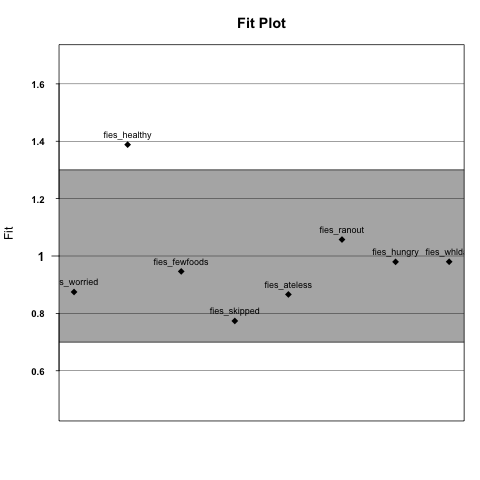

In [12]:
%%R
# Infit
infit <- rr.nigeria$infit

upper_bound <- rep(x = 1.3, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

# running fitgraph
fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.nigeria))

The plot shows the following observation:


* All the items fall with the **adequate in fit** (0.7 to 1.3), except for `fies_healthy`.
* The infit of `fies_healthy` is **above 1.3** and can be seen to be outside the acceptable range.
* The standard error of `fies_healthy` infit statistic is 0.06. This is narrow. A wide standard error indicates a less trustworthy result, and therefore provides weaker evidence for dropping the item
* By subtracting the standard error from the infit `(1.3881510-0.05997967 = 1.328)`,
we finds that it is still outside the acceptable range. As this strongly suggests that the item did not
perform well. **I wonders whether it would be preferable to drop it from the scale for the analysis**?

**Next**

Lets re-run the analysis without `fies_healthy` item.


[1] 0.6831787
           Item Item.Severity Stardard.Error     Infit Std.error.Infit
1  fies_worried     -2.043265     0.08690119 1.0050145      0.05222577
2 fies_fewfoods     -2.553615     0.09678387 1.1396224      0.05903185
3  fies_skipped     -1.362986     0.07754909 0.7764749      0.04765016
4  fies_ateless     -2.256910     0.09068035 0.9534118      0.05474804
5   fies_ranout      2.271511     0.06174452 1.0648560      0.03547751
6   fies_hungry      1.424200     0.05969779 0.9567670      0.03507751
7   fies_whlday      4.520971     0.10219012 0.9769712      0.08230446
     Outfit
1 1.6275424
2 3.7192210
3 0.7908849
4 1.8295200
5 1.1513956
6 1.0510076
7 2.7143962
              Weighted perc. of Yes Unweighted perc. of Yes
fies_worried                   0.88                    0.89
fies_fewfoods                  0.91                    0.90
fies_skipped                   0.83                    0.84
fies_ateless                   0.90                    0.87
fies_ranout           

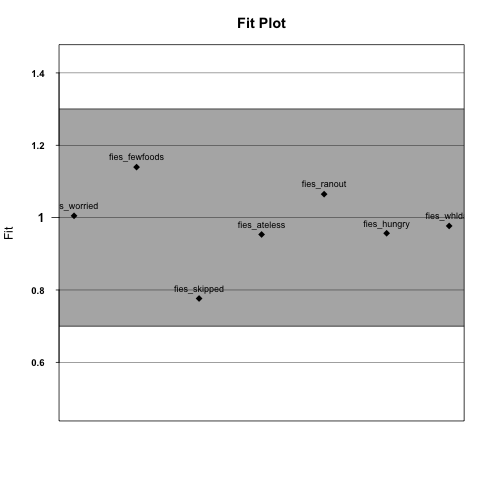

In [13]:
%%R
# Questionare data and weights
xx.ng_new <- subset(xx.nigeria, select = -fies_healthy)
wt.ng_new  <- fies.ng$weight_final

# # Fit weight rasch model
rr.ng_new  <- RM.w(xx.ng_new , wt.ng_new)
# Fit Rasch descriptives
fit.descr = tab.weight(wt = wt.ng_new, XX = xx.ng_new)

# # # Fit unweighted Rasch
rr.ng_new.nw <- RM.w(xx.ng_new )

fit_stats <- tibble::rownames_to_column(
  data.frame(
    "Item Severity" = rr.ng_new$b,              # Item severity estimate
    "Stardard Error" = rr.ng_new$se.b,          # Item standard error
    "Infit" = rr.ng_new$infit,                  # Infit
    "Std error Infit" = rr.ng_new$se.infit,     # standard error infit
    "Outfit" = rr.ng_new$outfit
  ),
  var = "Item"
)



# # what about outfit?
infit <- rr.ng_new$infit


upper_bound <- rep(x = 1.3, times = 7)
lower_bound <- rep(x = .70, times = 7) 

fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.ng_new))

print(rr.ng_new$reliab)
print(fit_stats)
print(cbind("Weighted perc. of Yes" = fit.descr$Perc.Yes.w,
"Unweighted perc. of Yes" = fit.descr$Perc.Yes))

* The Model reliability goes down from 0.71 to 0.68. This is expected as the reliability depends on the number of items in the scale.
* One of the Rasch model assumptions is that all items discriminate equally, which
means that, ideally, all infit statistics would be 1.0. Infit values in the range of 0.7-1.3
are generally considered to meet the model assumption of equal discrimination to an
acceptable degree. **Infit statistics in the range 1.3 to 1.5** identify items that can still be
used for measurement, but attention to possible improvement of such item may be
worthwhile.

**Impact**

* The  misfit does not justify omitting `fies_healthy` item from the scale.

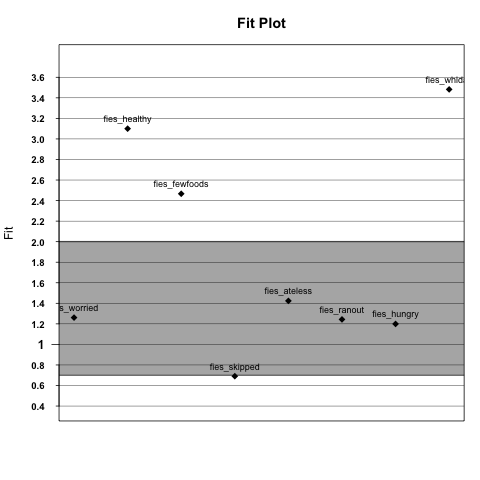

In [14]:
%%R
# # what about outfit?
outfit <- rr.nigeria$outfit


upper_bound <- rep(x = 2.0, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

fitgraph(fitEst = outfit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.nigeria))

* `fies_healthy`, `fies_fewfoods` and `fies_whlday` items have outfit of >2.
* Outfit statistics have a similar interpretation to the infit statistics, but are sensitive to
the presence of even just a few cases with highly unexpected response patterns, and are therefore
useful to flag the presence of outliers

#### Fit statistics - Residual correlation matrix

A residual correlation between a pair of items is considered high if it is >|0.4|

corrplot 0.92 loaded


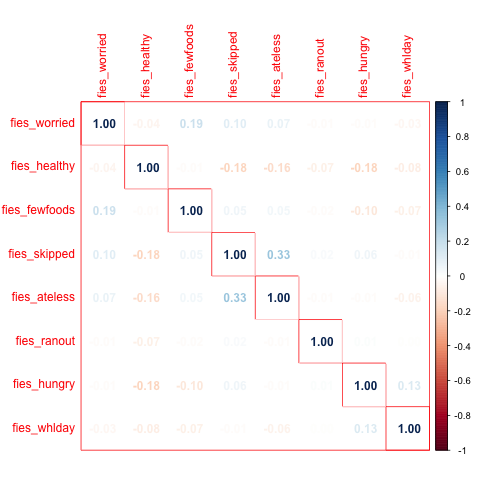

In [15]:
%%R
library(corrplot)
#  Residual correlation matrix 

# Set the threshold value for highlighting
threshold <- 0.4

cor_matrix <- rr.nigeria$res.corr

# Define colors for highlighting
highlight_color <- ifelse(abs(cor_matrix) > threshold, "red", "white")

# Plot the correlation matrix with highlighted values
corrplot(cor_matrix, method = "number", addgrid.col = highlight_color)

# corrplot(cor_matrix, method = "square", addCoef.col = "black")


**Observation**

* No pair of item have a correlation the high (0.4)
* Each item is seems to capture a different aspect of food insecurity, there are no redundant questions that would tend to weaken the ability to measure food insecurity accurately.

### Calculation of Prevalence of Food Insecurity 

* To obtain internationally comparable estimates of the prevalence of FI (`FImod+sev and FIsev`) we performed an equating method as suggested by the FAO and by utilizing an official FAO Excel [template](https://www.fao.org/fileadmin/user_upload/voices_of_the_hungry/docs/EPE_Example_05.xlsx).

* The correlation